In [3]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.4 MB/s eta 0:00:00


📥 Intentando descargar datos oficiales de COVID-19...
   ...Probando fuente: https://covid.ourworldindata.org/data/owid-covid-data.csv
      ⚠️ Falló intento 1: <urlopen error [Errno -2] Name or service not known>
      ⚠️ Falló intento 2: <urlopen error [Errno -2] Name or service not known>
      ⚠️ Falló intento 3: <urlopen error [Errno -2] Name or service not known>
   ...Probando fuente: https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv


[I 2025-12-02 18:18:01,248] A new study created in memory with name: no-name-06644328-4599-40a3-9d2d-ddfc11236bf9
[I 2025-12-02 18:18:01,289] Trial 0 finished with value: 15645.45633611528 and parameters: {'R0': 1.4471524704814946, 'D_infectious': 11.167338113449937, 'D_incubation': 3.0854398667627683, 'I0_seed': 131}. Best is trial 0 with value: 15645.45633611528.


✅ ¡Descarga exitosa!
✅ Datos listos: 273 días de la Primera Ola 2020.
🧠 Entrenando modelo con Optuna...


[I 2025-12-02 18:18:01,311] Trial 1 finished with value: 91399.62143408557 and parameters: {'R0': 1.4979416964204275, 'D_infectious': 7.482984154184763, 'D_incubation': 4.41468090604019, 'I0_seed': 164}. Best is trial 0 with value: 15645.45633611528.
[I 2025-12-02 18:18:01,329] Trial 2 finished with value: 201747.82980961137 and parameters: {'R0': 2.2208770179680135, 'D_infectious': 13.678176142785121, 'D_incubation': 5.4997096955227125, 'I0_seed': 63}. Best is trial 0 with value: 15645.45633611528.
[I 2025-12-02 18:18:01,340] Trial 3 finished with value: 13022.901233821924 and parameters: {'R0': 1.3786670419473328, 'D_infectious': 7.800706705701654, 'D_incubation': 6.1290715535697355, 'I0_seed': 379}. Best is trial 3 with value: 13022.901233821924.
[I 2025-12-02 18:18:01,355] Trial 4 finished with value: 5169.069725400187 and parameters: {'R0': 1.5298311317682773, 'D_infectious': 13.405464771730278, 'D_incubation': 6.748534972232333, 'I0_seed': 299}. Best is trial 4 with value: 5169.0


🏆 PARÁMETROS ÓPTIMOS ENCONTRADOS:
   R0 Promedio: 1.40
   Días Infeccioso: 11.3
   Días Incubación: 4.2


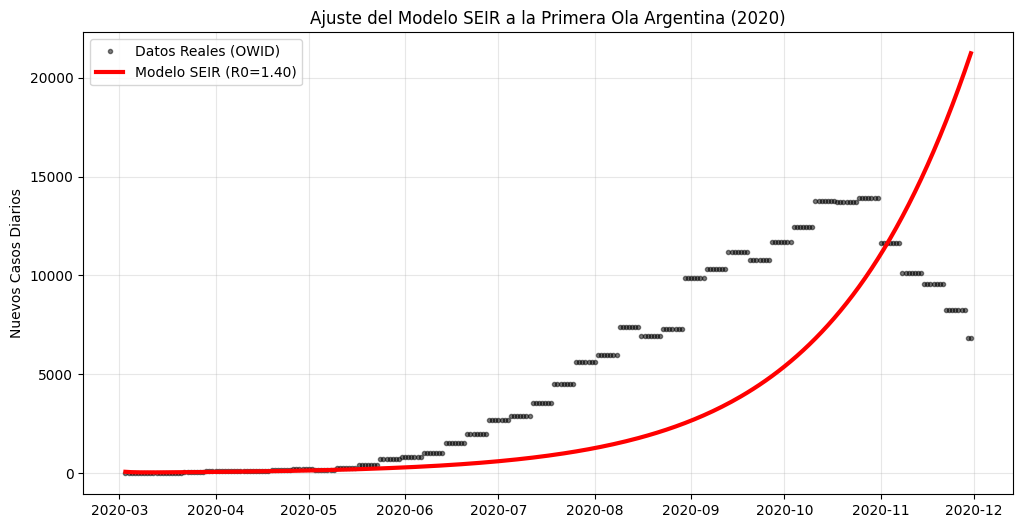

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
import optuna
import time

# ==========================================
# 1. CARGA ROBUSTA DE DATOS (Múltiples Fuentes)
# ==========================================
print("📥 Intentando descargar datos oficiales de COVID-19...")

# Lista de URLs: Principal (OWID) y Respaldo (GitHub Mirror)
urls = [
    "https://covid.ourworldindata.org/data/owid-covid-data.csv",
    "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
]

df_raw = None
download_success = False

for url in urls:
    if download_success: break
    print(f"   ...Probando fuente: {url}")

    for attempt in range(3): # 3 intentos por cada URL
        try:
            # Timeout para no colgar el proceso
            df_raw = pd.read_csv(url, usecols=['location', 'date', 'new_cases_smoothed'])
            print("✅ ¡Descarga exitosa!")
            download_success = True
            break
        except Exception as e:
            print(f"      ⚠️ Falló intento {attempt+1}: {e}")
            time.sleep(2) # Esperar 2 segs antes de reintentar

if not download_success:
    raise RuntimeError("❌ No se pudieron descargar los datos de ninguna fuente. Revisa tu conexión.")

# ==========================================
# 2. PROCESAMIENTO (Argentina 2020 - Sin Vacunas)
# ==========================================
# Filtramos Argentina
df_arg = df_raw[df_raw['location'] == 'Argentina'].copy()
df_arg['date'] = pd.to_datetime(df_arg['date'])

# Recortamos la "Primera Ola" (Marzo a Noviembre 2020)
start_date = '2020-03-03'
end_date = '2020-11-30'
mask = (df_arg['date'] >= start_date) & (df_arg['date'] <= end_date)
data = df_arg.loc[mask].reset_index(drop=True)

# Rellenar nulos iniciales con 0
data['new_cases_smoothed'] = data['new_cases_smoothed'].fillna(0)

y_real = data['new_cases_smoothed'].values
dias = np.arange(len(y_real))

print(f"✅ Datos listos: {len(y_real)} días de la Primera Ola 2020.")

# ==========================================
# 3. MODELO SEIR (Ecuaciones Diferenciales)
# ==========================================
N = 45_000_000 # Población aprox Argentina

def deriv_seir(y, t, N, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = (beta * S * I / N) - (sigma * E)
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

def run_seir_model(beta, sigma, gamma, I0, E0, days):
    S0 = N - I0 - E0
    R0_res = 0
    y0 = S0, E0, I0, R0_res
    t = np.linspace(0, days-1, days)

    ret = odeint(deriv_seir, y0, t, args=(N, beta, sigma, gamma))
    S, E, I, R = ret.T

    # Nuevos Casos Diarios = Personas que pasan de Expuesto a Infectado (sigma * E)
    new_cases_model = sigma * E
    return new_cases_model

# ==========================================
# 4. OPTIMIZACIÓN (Optuna)
# ==========================================
def objective(trial):
    # R0 Efectivo promedio para toda la ola (con cuarentena incluida)
    R0 = trial.suggest_float("R0", 1.1, 2.5)

    # Días que una persona contagia (1/gamma)
    D_infectious = trial.suggest_float("D_infectious", 5.0, 14.0)

    # Días de incubación (1/sigma)
    D_incubation = trial.suggest_float("D_incubation", 3.0, 7.0)

    # Semilla inicial de infectados ocultos
    I0_seed = trial.suggest_int("I0_seed", 1, 500)

    gamma = 1.0 / D_infectious
    sigma = 1.0 / D_incubation
    beta = R0 * gamma

    try:
        y_pred = run_seir_model(beta, sigma, gamma, I0_seed, I0_seed*2, len(y_real))
        rmse = np.sqrt(mean_squared_error(y_real, y_pred))
        return rmse
    except:
        return float('inf')

print("🧠 Entrenando modelo con Optuna...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50) # 50 intentos rápidos

# ==========================================
# 5. RESULTADOS
# ==========================================
best = study.best_params
print("\n🏆 PARÁMETROS ÓPTIMOS ENCONTRADOS:")
print(f"   R0 Promedio: {best['R0']:.2f}")
print(f"   Días Infeccioso: {best['D_infectious']:.1f}")
print(f"   Días Incubación: {best['D_incubation']:.1f}")

# Graficar Mejor Modelo vs Realidad
gamma_opt = 1.0 / best['D_infectious']
sigma_opt = 1.0 / best['D_incubation']
beta_opt = best['R0'] * gamma_opt

y_best = run_seir_model(beta_opt, sigma_opt, gamma_opt, best['I0_seed'], best['I0_seed']*2, len(y_real))

plt.figure(figsize=(12, 6))
plt.plot(data['date'], y_real, 'k.', label='Datos Reales (OWID)', alpha=0.5)
plt.plot(data['date'], y_best, 'r-', linewidth=3, label=f'Modelo SEIR (R0={best["R0"]:.2f})')
plt.title('Ajuste del Modelo SEIR a la Primera Ola Argentina (2020)')
plt.ylabel('Nuevos Casos Diarios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()